In [1]:
#Link to google drive
from google.colab import drive
drive.mount('/content/drive')

import os

#segmentation folder contains data, weights folder
#data contains Drinks dataset folder
os.chdir("drive/My Drive/Segmentation")
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['data',
 'prediction_1',
 'input_image.png',
 'segmentation.png',
 'background.png',
 'prediction_final',
 'prediction',
 'miou_history.npy',
 'mpla_history.npy',
 'weights']

In [2]:
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import skimage

from skimage.io import imread
from torch.utils.data import Dataset
from skimage import io

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DrinksDataset(Dataset):
    def __init__(self, label_file, root_dir, batch_size = 1, shuffle = True, transform = None):
        
        self.label_file = label_file
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.get_dictionary()
        self.on_epoch_end()
        
    def __len__(self):
        """Get total number of batches"""
        length = np.floor(len(self.dictionary) / self.batch_size)
        return int(length)
    
    def __getitem__(self, index):
        """Get a batch of data"""
        start_index = index * self.batch_size
        end_index = (index+1) * self.batch_size
        keys = self.keys[start_index : end_index]
        x, y = self.__data_generation(keys)
        return x, y
    
    def get_dictionary(self):
        """Load ground truth dictionary of 
            image filename : segmentation masks
        """
        path = os.path.join(self.root_dir,
                            self.label_file)
        self.dictionary = np.load(path,
                                  allow_pickle=True).flat[0]
        self.keys = np.array(list(self.dictionary.keys()))
        labels = self.dictionary[self.keys[0]]
        self.n_classes = labels.shape[-1]
        
    def on_epoch_end(self):
        """Shuffle after each epoch"""
        if self.shuffle == True:
            np.random.shuffle(self.keys)


    def __data_generation(self, keys):
        """Generate train data: images and 
        segmentation ground truth labels 

        Arguments:
            keys (array): Randomly sampled keys
                (key is image filename)

        Returns:
            x (tensor): Batch of images
            y (tensor): Batch of pixel-wise categories
        """
        # a batch of images
        x = []
        # and their corresponding segmentation masks
        y = []

        for i, key in enumerate(keys):
            # images are assumed to be stored 
            # in self.data_path
            # key is the image filename
            
            image_path = os.path.join(self.root_dir, key)
            image = skimage.img_as_float(imread(image_path))
            # append image to the list
            x.append(image)
            # and its corresponding label (segmentation mask)
            labels = self.dictionary[key]
            y.append(labels)

        return np.array(x), np.array(y)

In [3]:
class resnet_layer(nn.Module):
    def __init__(self,
                 in_channels = 3,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=False):
        
        super(resnet_layer, self).__init__()
        
        #set attributes
        self.conv_first = conv_first
        self.batch_normalization = batch_normalization
        self.activation = activation
        
        self.padding = int((kernel_size-1)/2)
        self.channels = num_filters
        
        #conv layer
        self.conv = nn.Conv2d(in_channels = in_channels,
                              out_channels = num_filters,
                              kernel_size = kernel_size,
                              stride = strides,
                              padding = self.padding
                              )
        
        #he normal initialization
        nn.init.kaiming_normal_(self.conv.weight) 
        
        #batch norm
        self.bn = nn.BatchNorm2d(in_channels)
        
        #change batch norm if conv_first is True
        if self.conv_first:
            self.bn = nn.BatchNorm2d(num_filters)
    
    #forward code
    def forward(self, x):
        if self.conv_first:
            x = self.conv(x)
            if self.batch_normalization:
                x = self.bn(x)
            if self.activation is not None:
                if self.activation == 'relu':
                    x = F.relu(x)
        else:
            if self.batch_normalization:
                x = self.bn(x)
            if self.activation is not None:
                if self.activation == 'relu':
                    x = F.relu(x)
            x = self.conv(x)
        
        return x

In [4]:
class resnet_v1(nn.Module):
    def __init__(self, in_channels, depth, n_layers=4):
        super(resnet_v1, self).__init__()
        
        self.in_channels = in_channels
        self.depth = depth
        self.n_layers = n_layers
        
        if (depth - 2) % 6 != 0:
            raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
        # Start model definition
        self.num_filters = 16
        self.num_res_blocks = int((depth - 2) / 6)
        
        #List of resnet, allows to be seen as modules
        self.res_x = nn.ModuleList()
        self.res_y = nn.ModuleList()
        
        #layers
        self.res_x.append(resnet_layer(in_channels = in_channels))
        
        # Instantiate the stack of residual units
        for stack in range(3):
            for res_block in range(self.num_res_blocks):
                strides = 1
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides = 2  # downsample
                    
                #in channel = out channel of previous layer
                self.res_y.append(resnet_layer(in_channels=self.res_x[len(self.res_x)-1].channels,
                                               num_filters=self.num_filters,
                                               strides=strides
                                              ))
                
                #in channel = out channel of previous layer
                self.res_y.append(resnet_layer(in_channels=self.res_y[len(self.res_y)-1].channels,
                                               num_filters=self.num_filters,
                                               activation=None
                                              ))
                
                
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    # linear projection residual shortcut connection to match
                    # changed dims
                    self.res_x.append(resnet_layer(in_channels=self.res_x[len(self.res_x)-1].channels,
                                                   num_filters=self.num_filters,
                                                   kernel_size=1,
                                                   strides=strides,
                                                   activation=None,
                                                   batch_normalization=False))
                    
                    
        self.feat_pyramid = features_pyramid(in_channels = self.num_filters,
                                            n_layers = self.n_layers
                                           )
        
        #can be called by other functions
        self.out_channels = self.num_filters
        
    def forward(self, x):    

        #making resnet indices
        x_ind = -1
        y_ind = -1
        
        x_ind += 1
        x = self.res_x[x_ind](x)
        #print("x.shape:", x.shape)
         
        # Instantiate the stack of residual units
        for stack in range(3):
            #print("stack:", stack)
            for res_block in range(self.num_res_blocks):
                y_ind += 1
                y = self.res_y[y_ind](x)
                #print("y.shape:", y.shape)
                
                y_ind += 1
                y = self.res_y[y_ind](y)
                #print("y.shape:", y.shape)
                
                
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x_ind += 1
                    x = self.res_x[x_ind](x)
                    #print("x.shape:", x.shape)
                
                #x and y went through diff. paths
                x = x.add(y)
                x = F.relu(x)
                
            self.num_filters *= 2

        # feature maps
        outputs = self.feat_pyramid(x) #replaced num_classes with n_layers

        return outputs #not x?


In [5]:
class features_pyramid(nn.Module):
    def __init__(self,in_channels = 3, n_layers=4):
        super(features_pyramid, self).__init__()
        
        """Generate features pyramid from the output of the 
        last layer of a backbone network (e.g. ResNetv1 or v2)

        Arguments:
            x (tensor): Output feature maps of a backbone network
            n_layers (int): Number of additional pyramid layers

        Return:
            outputs (list): Features pyramid 
        """
        
        n_filters = 512
        channels = in_channels
        
        self.n_layers = n_layers
        
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        
        self.layers = nn.ModuleList()

        # additional feature map layers
        for i in range(self.n_layers - 1):
            self.layers.append(conv_layer(in_channels = channels,
                                          num_filters = n_filters,
                                          kernel_size=3,
                                          strides=2,
                                          use_maxpool=False
                                         ))
            channels = n_filters
            
            
            
            
    def forward(self, x):
        outputs = [x]
        conv = self.avgpool(x)
        outputs.append(conv)
        prev_conv = conv

        # additional feature map layers
        for i in range(self.n_layers - 1):

            conv = self.layers[i](prev_conv)
            
            outputs.append(conv)
            prev_conv = conv
            
        return outputs


In [6]:
class conv_layer(nn.Module):
    def __init__(self,
                 in_channels = 3,
                 num_filters=32,
                 kernel_size=3,
                 strides=1,
                 use_maxpool=True,
                 activation='relu',
                ):
        
        super(conv_layer, self).__init__()
        
        #set attributes
        self.in_channels = in_channels
        self.activation = activation
        self.use_maxpool = use_maxpool
        self.padding = int((kernel_size-1)/2)
        
        self.conv = nn.Conv2d(in_channels = self.in_channels, 
                      out_channels = num_filters,
                      kernel_size = kernel_size,
                      stride = strides,
                      padding = self.padding #p = (f-1)/2
                     )
        
        self.bn = nn.BatchNorm2d(num_filters)
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        
        #HE NORMAL INITIALIZATION
        nn.init.kaiming_normal_(self.conv.weight) 
    
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.activation == 'relu':
            x = F.relu(x)
        if self.use_maxpool:
            x = self.maxpool(x)
        return x

In [7]:
class resnet_v2(nn.Module):
    def __init__(self, in_channels, depth, n_layers=4):
        super(resnet_v2, self).__init__()
        
        self.in_channels = in_channels
        self.depth = depth
        self.n_layers = n_layers
        
        if (self.depth - 2) % 9 != 0:
            raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
        # Start model definition.
        num_filters_in = 16
        num_filters_out = 0
        self.num_res_blocks = int((self.depth - 2) / 9)

        #List of resnet, allows to be seen as modules
        self.res_x = nn.ModuleList()
        self.res_y = nn.ModuleList()
        
        #LAYERS
        self.res_x.append(resnet_layer(in_channels = in_channels,
                                      num_filters = num_filters_in,
                                      conv_first = True
                                      ))
        
        # Instantiate the stack of residual units
        for stage in range(3):
            for res_block in range(self.num_res_blocks):
                activation = 'relu'
                batch_normalization = True
                strides = 1
                if stage == 0:
                    num_filters_out = num_filters_in * 4
                    if res_block == 0:  # first layer and first stage
                        activation = None
                        batch_normalization = False
                else:
                    num_filters_out = num_filters_in * 2
                    if res_block == 0:  # first layer but not first stage
                        strides = 2    # downsample
                        
                        
                # bottleneck residual unit
                self.res_y.append(resnet_layer(in_channels=self.res_x[len(self.res_x)-1].channels,
                                               num_filters=num_filters_in,
                                               kernel_size = 1,
                                               strides=strides,
                                               activation=activation,
                                               batch_normalization=batch_normalization,
                                               conv_first=False
                                              ))
                
                #in channel = out channel of previous layer
                self.res_y.append(resnet_layer(in_channels=self.res_y[len(self.res_y)-1].channels,
                                               num_filters=num_filters_in,
                                               conv_first=False
                                              ))
                
                self.res_y.append(resnet_layer(in_channels=self.res_y[len(self.res_y)-1].channels,
                                               num_filters=num_filters_out,
                                               kernel_size=1,
                                               conv_first=False
                                              ))
                if res_block == 0:
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x = self.res_x.append(resnet_layer(in_channels=self.res_x[len(self.res_x)-1].channels,
                                                       num_filters=num_filters_out,
                                                       kernel_size=1,
                                                       strides=strides,
                                                       activation=None,
                                                       batch_normalization=False
                                                      ))

            num_filters_in = num_filters_out
        
        self.bn = nn.BatchNorm2d(num_filters_out)
        
        self.feat_pyramid = features_pyramid(in_channels = num_filters_out,
                                            n_layers = self.n_layers
                                           )
        #can be called by other functions
        self.out_channels = num_filters_out
    
    def forward(self, x):    
        
        #making resnet indices
        x_ind = -1
        y_ind = -1
        
        
        # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
        x_ind += 1
        x = self.res_x[x_ind](x)
        #print("x.shape:", x.shape)

        
        # Instantiate the stack of residual units
        for stage in range(3):
            for res_block in range(self.num_res_blocks):
                
                # bottleneck residual unit
                y_ind += 1  
                y = self.res_y[y_ind](x)
                #print("y.shape:", y.shape)
                
                y_ind += 1
                y = self.res_y[y_ind](y)
                #print("y.shape:", y.shape)
                
                y_ind += 1
                y = self.res_y[y_ind](y)
                #print("y.shape:", y.shape)
                
                if res_block == 0:
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x_ind += 1
                    x = self.res_x[x_ind](x)
                    #print("x.shape:", x.shape)
                
                x = x.add(y) #add 2 outputs together

        # v2 has BN-ReLU before Pooling
        x = self.bn(x)
        x = F.relu(x)
        # 1st feature map layer

        # main feature maps (160, 120)
        # succeeding feature maps are scaled down by
        # 2, 4, 8
        outputs = self.feat_pyramid(x)
        
        return outputs #returns list of feature maps

In [8]:
def build_resnet(in_channels=3,
                 n_layers=4,
                 version=1,
                 n=6):
    """Build a resnet as backbone

    # Arguments:
        input_shape (list): Input image size and channels
        n_layers (int): Number of feature layers 
        version (int): Supports ResNetv1 and v2 but v2 by default
        n (int): Determines number of ResNet layers
                 (Default is ResNet50)

    # Returns
        model (Keras Model)

    """
    # computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # model name, depth and version
    # input_shape (h, w, 3)
    if version==1:
        model = resnet_v1(in_channels=in_channels,
                          depth=depth,
                          n_layers=n_layers)
    else:
        model = resnet_v2(in_channels=in_channels,
                          depth=depth,
                          n_layers=n_layers)
    
    #RETURNS RESNET MODEL IN PYTORCH
    return model

In [9]:
class tconv_layer(nn.Module):
    def __init__(self,
                 in_channels = 3,
                 num_filters=32,
                 kernel_size=3,
                 strides=2
                ):
        """Helper function to build Conv2DTranspose-BN-ReLU 
            layer
        """
        super(tconv_layer, self).__init__()
        
        self.padding = int((kernel_size-1)/2)
        
        self.in_channels = in_channels

        self.tconv = nn.ConvTranspose2d(in_channels = self.in_channels, 
                                        out_channels=num_filters,
                                        kernel_size=kernel_size,
                                        stride=strides,
                                        padding=self.padding,
                                        output_padding = 1
                                       )
        
        #HE NORMAL INITIALIZATION
        nn.init.kaiming_normal_(self.tconv.weight)
        
        self.bn = nn.BatchNorm2d(num_filters)
    
    def forward(self, x):
        x = self.tconv(x)
        x = self.bn(x)
        x = F.relu(x)
            
        return x

In [10]:
class build_fcn(nn.Module):
    def __init__(self,
                 backbone,
                 n_classes=4
                ):
        """Helper function to build Conv2DTranspose-BN-ReLU 
            layer
        """
        super(build_fcn, self).__init__()
        
        self.backbone = backbone
        
    
        #can be called by other functions
        channels = backbone.out_channels
        
        self.layers = nn.ModuleList()
        self.upsample = nn.ModuleList()
        
        size = 2
        
        for i in range(backbone.n_layers):
            if i>0:
                channels = 512
                
            self.layers.append(conv_layer(channels,
                                 num_filters=256,
                                 use_maxpool=False))

            #used scale_factor instead of size in keras
            self.upsample.append(nn.Upsample(scale_factor=size, mode='bilinear', align_corners = False))

            size = size * 2
            
            
        tconv_in_channel = 256 * backbone.n_layers + backbone.out_channels
        
        self.tconv1 = tconv_layer(in_channels = tconv_in_channel, num_filters = 256)
        self.tconv2 = tconv_layer(in_channels = 256, num_filters = 256)
        
        self.tconv3 = nn.ConvTranspose2d(in_channels = 256, 
                                        out_channels = n_classes,
                                        kernel_size = 1,
                                        stride = 1,
                                        padding = 0
                                       )
        
    def forward(self, x):
        
        features = self.backbone(x)
        main_feature = features[0]
        features = features[1:]
        out_features = [main_feature]
        
        for i, feature in enumerate(features):
            feature = self.layers[i](feature)

            #used scale_factor instead of size in keras
            feature = self.upsample[i](feature)

            out_features.append(feature)
        
        # concatenate all upsampled features
        x = torch.cat(out_features, 1) #along which axes to concatenate?
        #print("cat:", x.shape)
        # perform 2 additional feature extraction 
        # and upsampling
        x = self.tconv1(x)
        #print("tconv1:", x.shape)
        x = self.tconv2(x)        
        #print("tconv2:", x.shape)
        
        #pixel-wise classifier
        x = self.tconv3(x)
        #print("tconv3:", x.shape)
        #x = nn.Softmax(dim=1)(x)
        
        
        return x

In [11]:
import time

class FCN(nn.Module):
    """Made of an fcn model and a dataset generator.
    Define functions to train and validate an FCN model.

    Attributes:
        fcn (model): FCN network model
        train_generator: Multi-threaded 
            data generator for training
    """
    
    
    def __init__(self, restore_weights_path = "", label_file = "segmentation_train.npy", 
                 n_layers = 3, backbone = build_resnet, 
                 transform = None, image_file = None,
                 test_labels = "segmentation_test.npy",
                 root_dir = "data/drinks", batch_size = 1, shuffle = True,
                 dataset = "drinks", epochs = 5, plot = True,
                 in_channels = 3, save_dir = "weights",
                 evaluate = False, train = False, save = False, device = 'cpu'
                ):
        super(FCN, self).__init__()
            
        """Copy user-defined configs.
        Build backbone and fcn network models.
        """
        self.in_channels = in_channels
        self.backbone_net = backbone
        self.n_layers = n_layers
        self.save_dir = save_dir
        self.root_dir = root_dir
        self.test_labels = test_labels
        self.batch_size = batch_size
        self.dataset = dataset
        self.epochs = epochs
        self.restore_weights_path = restore_weights_path
        self.image_file = image_file
        self.plot = plot
        self.save = save
        self.device = device

        #initialize total loss
        self.total_loss = 0

        #initialize epoch
        self.curr_epoch = -1
        
        
        if transform is None:
            transform = transforms.ToTensor()
        
        
        self.fcn = None
        self.train_generator = DrinksDataset(label_file, root_dir, batch_size, 
                                             shuffle, transform)
        self.build_model()
        self.eval_init()
        
        """set these arguments to set what to do with the model."""
        if restore_weights_path != "":
            self.restore_weights()

        if train:
            self.train_network()

        if evaluate:
            if image_file is None:
                self.eval()
            else:
                self.evaluate()
        


    def build_model(self):
        """Build a backbone network and use it to
            create a semantic segmentation 
            network based on FCN.
        """
        
        # input shape is (3, 480, 640) by default
        

        # build the backbone network (eg ResNet50)
        # the backbone is used for 1st set of features
        # of the features pyramid
        self.backbone = self.backbone_net(self.in_channels,
                                          n_layers=self.n_layers)

        # using the backbone, build fcn network
        # output layer is a pixel-wise classifier
        #n_classes exists in train_generator
        self.n_classes =  self.train_generator.n_classes
        
        self.fcn = build_fcn(backbone = self.backbone, 
                             n_classes = self.n_classes
                            )
        
        print("Modules: ", self.fcn.modules)
        
        self.optimizer = optim.Adam(self.fcn.parameters(), lr = 0.001)

    def eval_init(self):
        """Housekeeping for trained model evaluation"""
        # model weights are saved for future validation
        # prepare model model saving directory.
        save_dir = os.path.join(os.getcwd(), self.save_dir)
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
                
        model_name = str(self.n_layers) + "layer-"
        model_name += self.dataset
        model_name += '-best-iou.h5'
        log = "Weights filename: %s" % model_name
        print(log)
        self.weights_path = os.path.join(save_dir, model_name)
        self.preload_test()
        self.miou = 0
        self.miou_history = []
        self.mpla_history = []


    def preload_test(self):
        """Pre-load test dataset to save time """
        path = os.path.join(self.root_dir,
                            self.test_labels)

        # ground truth data is stored in an npy file
        self.test_dictionary = np.load(path,
                                       allow_pickle=True).flat[0]
        self.test_keys = np.array(list(self.test_dictionary.keys()))
        print("Loaded %s" % path)
        
   
    #CHECK TRAIN ON OTHER PYTORCH CODE            
    def train_network(self):
        """Train an FCN"""
        log = "# of classes %d" % self.n_classes
        print(log)
        log = "Batch size: %d" % self.batch_size
        print(log)

        # prepare callbacks for saving model weights
        # and learning rate scheduler
        # model weights are saved when test iou is highest

        # learning rate decreases by 50% every 20 epochs
        # after 40th epoch        

        
        #GET PYTORCH LOOP
        #use .to('cuda') for network, images, labels to run on cuda.
        device = self.device

        #RUN ON CUDA
        self.fcn.to(device)
        
        """optimizer is in self.optimizer, adam"""

        torch.set_grad_enabled(True)
        
        #SET MODEL INTO TRAINING MODE
        self.fcn.train()

        print("Training network....")
        
        print("data length: " + str(len(self.train_generator)))
        if self.curr_epoch != -1:
            print("Epochs done:", self.curr_epoch)

        total_loss = self.total_loss

        for epoch in range(self.epochs):
            #skip until current epoch if weights are loaded
            if self.curr_epoch != -1 and epoch < self.curr_epoch:
                    continue

            #LR scheduler
            if(epoch > 38 and epoch < 82 and (epoch+1) % 20 == 0):
                for param in self.optimizer.param_groups:
                    temp = param['lr']
                    param['lr'] = temp/2
                print("epoch:", (epoch+1),"new lr:", param['lr'])
          
            t0 = time.perf_counter()

            for i, batch in enumerate(self.train_generator):
                if i == len(self.train_generator):
                    break
                
                images = torch.from_numpy(batch[0]).permute(0, 3, 1, 2).float().to(device) #RUN ON CUDA
                labels = torch.from_numpy(batch[1]).permute(0, 3, 1, 2).float() 
                
                preds = self.fcn(images)

                loss_func = torch.nn.CrossEntropyLoss()
                
                targets = np.argmax(labels, axis = 1).to(device) #RUN ON CUDA
                
                loss = loss_func(preds, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                
                print("batch:", i)
                self.batch = i
                print("time elapsed: ", time.perf_counter()-t0)
                print("total_loss:", total_loss)
                print("loss:", loss.item())

            #remove when loss is fixed
            self.total_loss = total_loss
            print("epoch:", epoch + 1, "out of", self.epochs, "done, total_loss:", total_loss)
            print("time elapsed: ", time.perf_counter()-t0)

        print("Done training!")
        if self.save == True:
                print("Saving weights... %s" % self.weights_path)
                #SAVE WEIGHTS FUNCTION FOR PYTORCH
                torch.save({
                    'epoch': (epoch+1),
                    'model_state_dict': self.fcn.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': self.total_loss
                }, self.weights_path)
      
        print("Weights are saved.")



    def restore_weights(self):
        """Load previously trained model weights"""
        #need to enter weight filename in restore_weights
        if self.restore_weights_path != "":
            save_dir = os.path.join(os.getcwd(), self.save_dir)
            filename = os.path.join(save_dir, self.restore_weights_path)
            log = "Loading weights: %s" % filename
            print(log)

            checkpoint = torch.load(filename)
            self.fcn.load_state_dict(checkpoint['model_state_dict'])
            self.fcn = self.fcn.to(self.device)

            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            #IMPLEMENT CURR EPOCH AND TOTAL LOSS IN TRAINING
            self.curr_epoch = checkpoint['epoch']
            self.total_loss = checkpoint['loss']

            print("Restored weights.")
         
        
    def to_categorical(self, y, num_classes):
        return np.eye(num_classes, dtype=y.dtype)[y]

    def segment_objects(self, image, normalized=True):
        """Run segmentation prediction for a given image
    
        Arguments:
            image (tensor): Image loaded in a numpy tensor.
                RGB components range is [0.0, 1.0]
            normalized (Bool): Use normalized=True for 
                pixel-wise categorical prediction. False if 
                segmentation will be displayed in RGB
                image format.
        """
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image).float().permute(0, 3, 1, 2).to(self.device)

        segmentation = self.fcn(image)
        segmentation = segmentation.permute(0, 2, 3, 1).detach().cpu().numpy()
        segmentation = np.squeeze(segmentation, axis=0)
        segmentation = np.argmax(segmentation, axis=-1)
        segmentation = self.to_categorical(segmentation, self.n_classes)
        if not normalized:
            segmentation = segmentation * 255
        segmentation = segmentation.astype('uint8')
        return segmentation


    def evaluate(self, imagefile=None, image=None):
        """Perform segmentation on a given image filename
            and display the results.
        """
        import matplotlib.pyplot as plt
        save_dir = "prediction"
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
            
            
            
        #CHANGED IMAGE WITH IMAGEFILE
        if image is not None:
            #splitext separates filename and extension, 0 is filename w/ root
            imagefile = os.path.splitext(imagefile)[0]
        elif self.image_file is not None:
            image = skimage.img_as_float(imread(self.image_file))
            imagefile = os.path.split(self.image_file)[-1]
            imagefile = os.path.splitext(imagefile)[0]
            print("imagefile:", imagefile)
        else:
            raise ValueError("Image file must be known")

        maskfile =imagefile + "-mask-epoch-"+str(self.epochs)+".png"
        mask_path = os.path.join(save_dir, maskfile)
        inputfile = imagefile + "-input.png"
        input_path = os.path.join(save_dir, inputfile)

        #image = torch.from_numpy(image).float().to(self.device)

        segmentation = self.segment_objects(image,
                                            normalized=False)
        mask = segmentation[..., 1:]
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Input image', fontsize=14)
        plt.imshow(image)
        plt.savefig(input_path)
        #plt.show()

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Semantic segmentation', fontsize=14)
        plt.imshow(mask)
        plt.savefig(mask_path)
        #plt.show()
        
    def eval(self):
        """Evaluate a trained FCN model using mean IoU
            metric.
        """
        print("Evaluating..")
        
        s_iou = 0
        s_pla = 0
        # evaluate iou per test image
        eps = np.finfo(float).eps
        for i, key in enumerate(self.test_keys):
            # load a test image
            image_path = os.path.join(self.root_dir, key)
            print("Loading img:", key)
            
            image = skimage.img_as_float(imread(image_path))
            segmentation = self.segment_objects(image) 
            # load test image ground truth labels
            gt = self.test_dictionary[key]
            i_pla = 100 * (gt == segmentation).all(axis=(2)).mean()
            s_pla += i_pla
            
            i_iou = 0
            n_masks = 0
            # compute mask for each object in the test image
            # including background
            for i in range(self.n_classes):
                if np.sum(gt[..., i]) < eps: 
                    continue
                mask = segmentation[..., i]
                intersection = mask * gt[..., i]
                union = np.ceil((mask + gt[..., i]) / 2.0)
                intersection = np.sum(intersection) 
                union = np.sum(union) 
                if union > eps:
                    iou = intersection / union
                    #print("iou of", n_masks, "is", iou)
                    i_iou += iou
                    n_masks += 1
            
            # average iou per image
            i_iou /= n_masks
            log = "%s: %d objs, miou=%0.4f ,pla=%0.2f%%"\
                  % (key, n_masks, i_iou, i_pla)
            print(log)

            # accumulate all image ious
            s_iou += i_iou
            
            if self.plot:
                self.evaluate(key, image)

        n_test = len(self.test_keys)
        m_iou = s_iou / n_test
        #load miou and mpla history
        if os.path.isfile("miou_history.npy"):
            self.miou_history = np.load("miou_history.npy")
            self.miou = np.amax(self.miou_history) 
        if os.path.isfile("mpla_history.npy"):
            self.mpla_history = np.load("mpla_history.npy")

        self.miou_history = np.append(self.miou_history, m_iou)
        np.save("miou_history.npy", self.miou_history)
        m_pla = s_pla / n_test

        self.mpla_history = np.append(self.mpla_history, m_pla)
        np.save("mpla_history.npy", self.mpla_history)

        if m_iou > self.miou:
            log = "\nOld best mIoU=%0.4f, New best mIoU=%0.4f, Pixel level accuracy=%0.2f%%"\
                    % (self.miou, m_iou, m_pla)
            print(log)
            self.miou = m_iou
            print("Saving weights... %s" % self.weights_path)
            #SAVE WEIGHTS FUNCTION FOR PYTORCH
            torch.save({
                'epoch': self.epochs,
                'model_state_dict': self.fcn.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': self.total_loss
            }, self.weights_path)
            
        else:
            log = "\nCurrent mIoU=%0.4f, Pixel level accuracy=%0.2f%%"\
                    % (m_iou, m_pla)

            print(log)

Modules:  <bound method Module.modules of build_fcn(
  (backbone): resnet_v1(
    (res_x): ModuleList(
      (0): resnet_layer(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): resnet_layer(
        (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(2, 2))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): resnet_layer(
        (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(2, 2))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_y): ModuleList(
      (0): resnet_layer(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): resnet_layer(
        (conv): Conv2d(16, 16, kernel_s

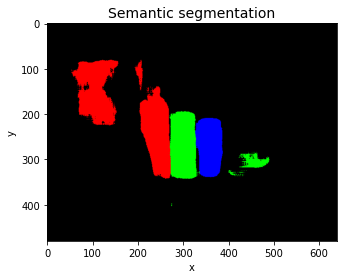

In [14]:
torch.cuda.empty_cache()

fcn = FCN(train = True, batch_size = 5, epochs = 40, 
          save = True, restore_weights_path = "3layer-drinks-best-iou.h5", evaluate = True, device = 'cuda')

In [ ]:
fcn.eval()

In [ ]:
path = "data/drinks/0000107.jpg"

fcn.evaluate(imagefile = path)